# Data Exploration

---

## Imports

In [1]:
import itertools
import json
import re
import string

import contractions
import emoji
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from wordcloud import WordCloud

## Data Load 

In [2]:
complete = pd.read_parquet("../data/clean_data.parquet")

## EDA 

### Sentiment Distribution 

We see that there are 28 classes of emotion, and that the dataset is highly unbaleced

In [3]:
def plot_distribution(dataset: str = "complete", classification: str = "goemotion", top: int = 15) -> None:
    global labels_map
    
    fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12,8))

    count = (
        complete[classification].value_counts()
        .reset_index()
        .rename(columns={classification: "emotion", "mapping": "emotion", "count": "occurences"})
    )

    explode = (count["occurences"] / count["occurences"].sum()).to_list()[:top]
    labels = count["emotion"].to_list()[:top]
    ax2.pie(explode, explode=explode, startangle=60, labels=labels, autopct="%1.0f%%", normalize=False, pctdistance=0.9)
    ax2.add_artist(plt.Circle((0, 0), 0.6, fc="white"))

    sns.barplot(data=count, x="occurences", y="emotion", ax=ax1)

    ax1.set_title("Count of each emotion")
    ax2.set_title(f"Percentage of each emotion (top {top})", x=0.5, y=1.1)

    plt.show()

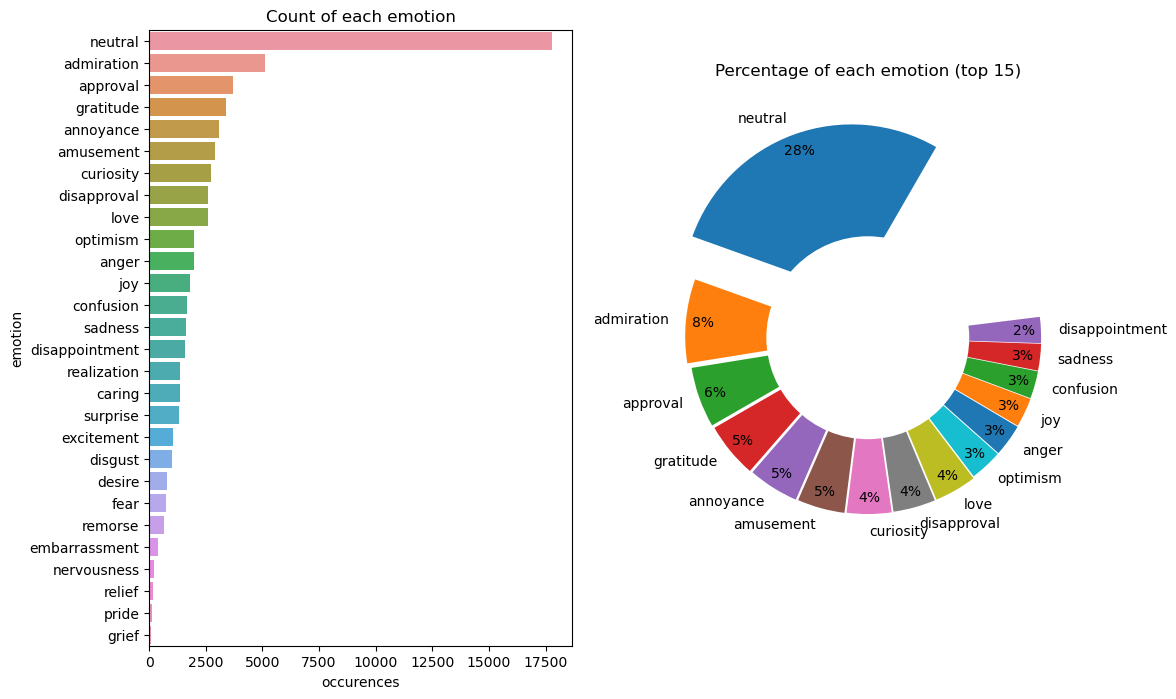

In [4]:
plot_distribution()

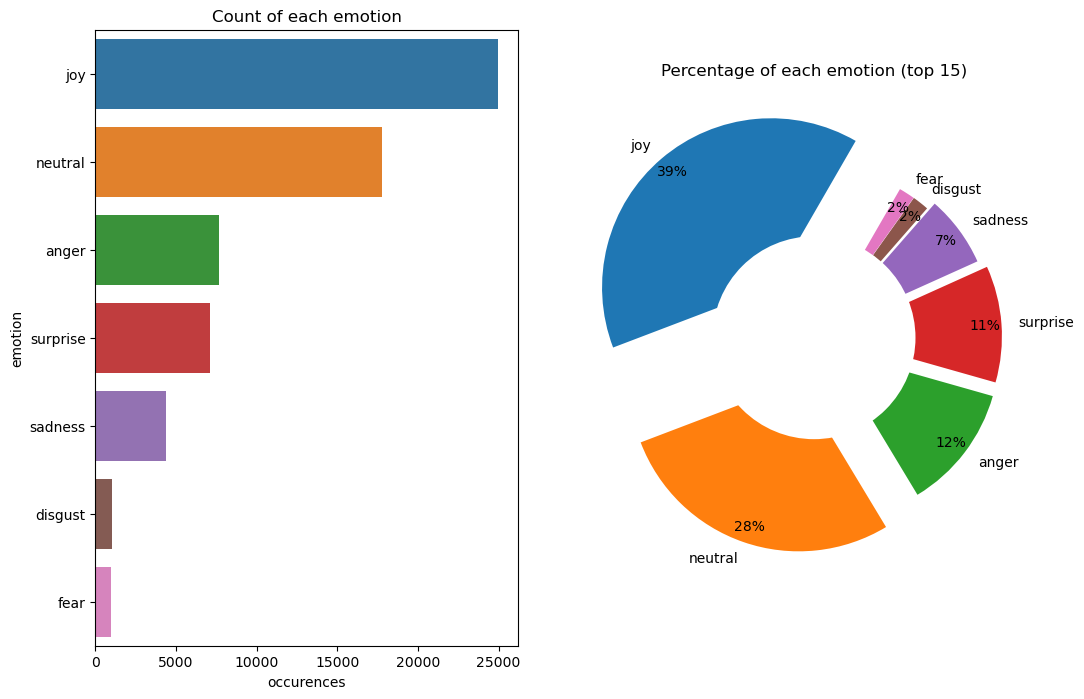

In [5]:
plot_distribution(classification="ekman")

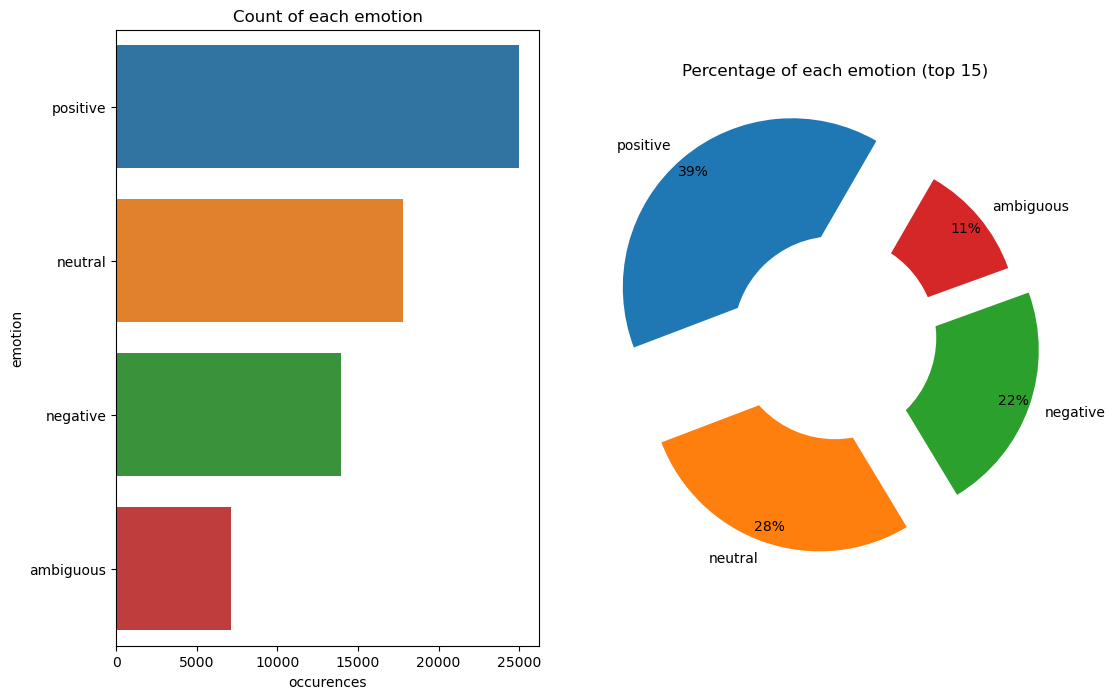

In [6]:
plot_distribution(classification="sentiment")

Moreover, we see that we have some data points where there are two emotions present. This represents 16% of the GoEmotions data. We can see from it that we have some pairs of emotions that are more common. For example, for sentences with a sadness emotion that have more than one emotion, it is very common to have it paired with grief.

In [7]:
def plot_emotions_cooccurences(dataset: str = "complete", classification: str = "goemotion"):
    global labels_map
    
    df = complete.pivot_table(index="code", columns=classification, values="text", aggfunc="count", fill_value=0)
    ax = sns.countplot(df.sum(axis=1).reset_index(), y=0)
    ax.set_title("Number of setences by number of emotions present")
    ax.set_ylabel("Number of Emotions")
    ax.set_xlabel("Number of Sentences")
    print(
        "Data points with more than one emotion: %.1f%%" 
        % (100 * df.sum(axis=1).loc[lambda f: f > 1].shape[0] / df.shape[0])
    )

    matrix = pd.DataFrame(
        df.apply(lambda x: [df.columns[i] for i, v in enumerate(x.values) if v == 1], axis=1)
        .apply(lambda x: [tuple(set(c)) for c in itertools.combinations(x, 2)])
        .apply(lambda x: x + [(p2, p1) for p1, p2 in x])
        .sum(),
        columns=["emotion_1", "emotion_2"]
    ).assign(count=1).pivot_table(index="emotion_1", columns="emotion_2", values="count", aggfunc="sum", fill_value=0)

    plt.figure(figsize=(16, 10))
    matrix = matrix / matrix.sum(axis=1)
    ax = sns.heatmap(matrix, cmap="coolwarm")
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    _ = ax.set_title("Emotions Co-occurances")

Data points with more than one emotion: 16.2%


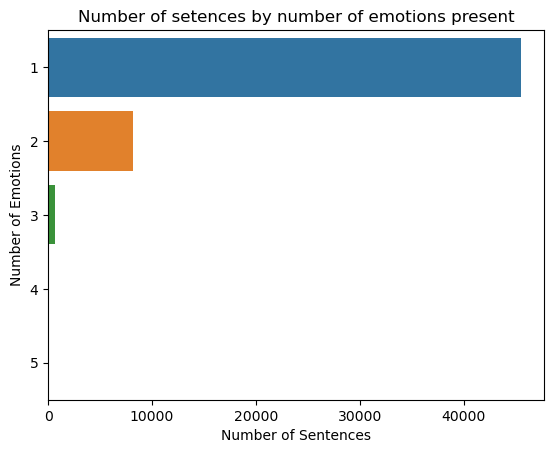

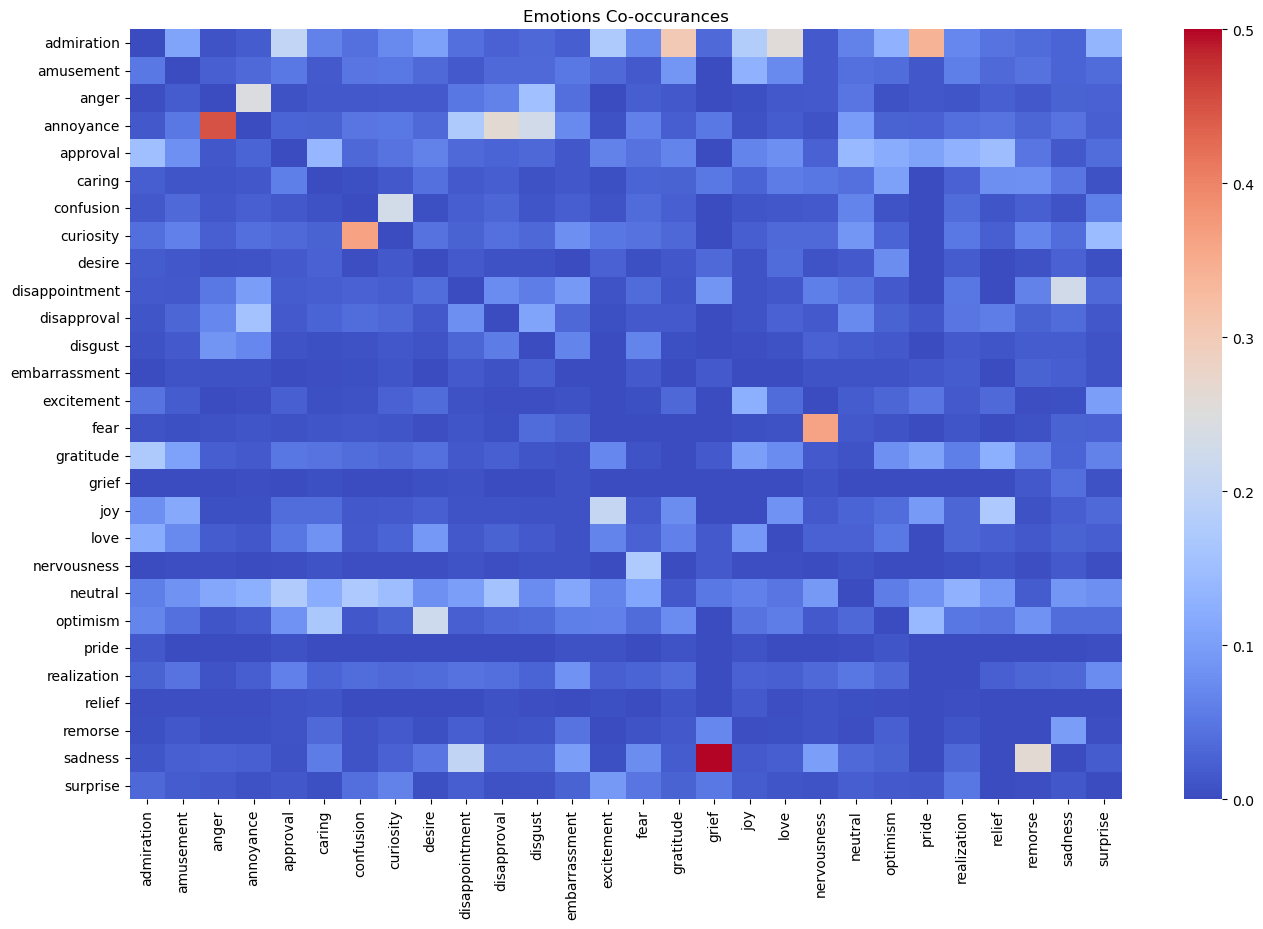

In [8]:
plot_emotions_cooccurences()

Data points with more than one emotion: 16.2%


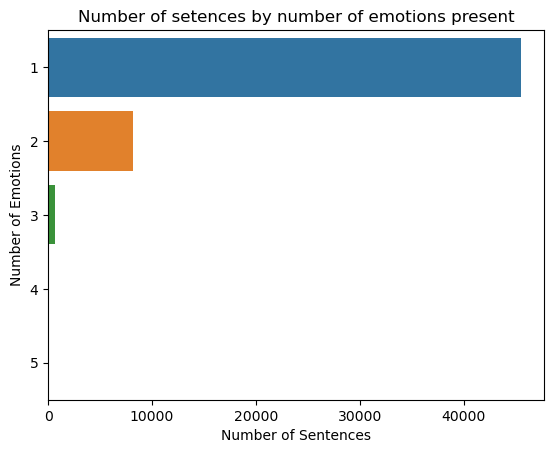

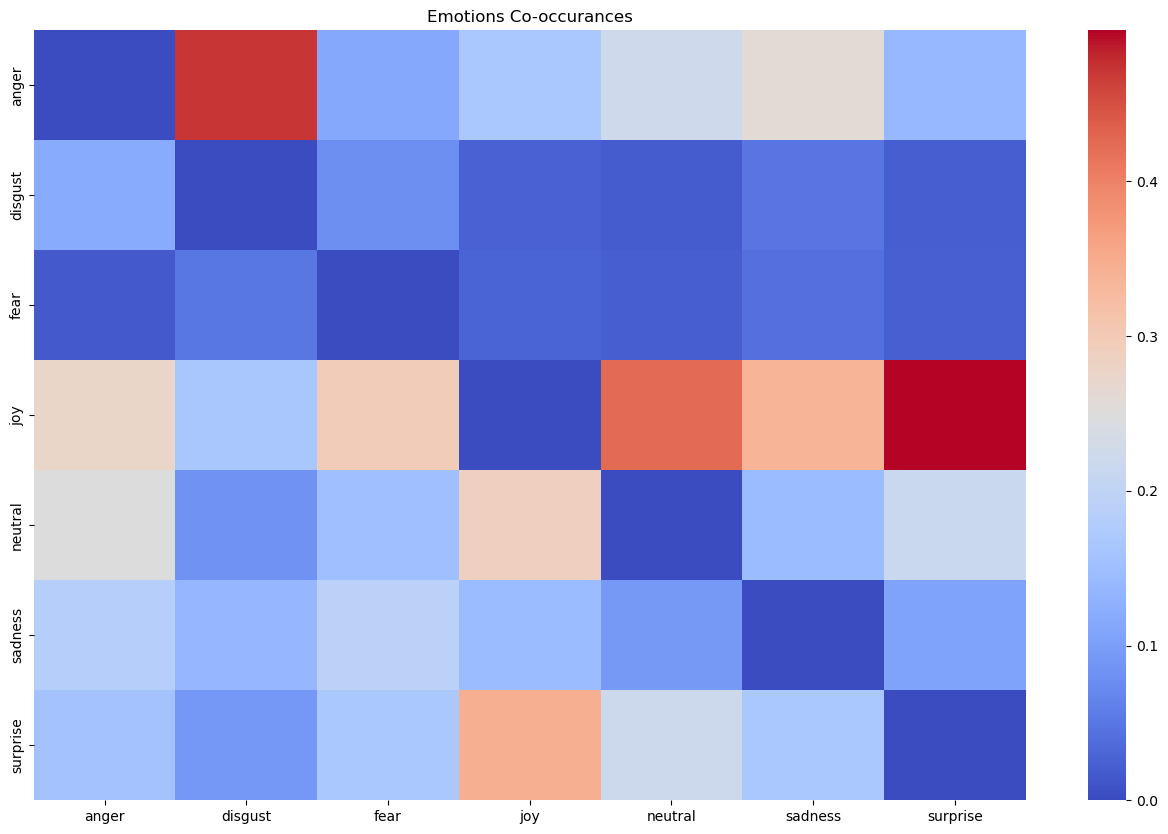

In [9]:
plot_emotions_cooccurences(classification="ekman")

Data points with more than one emotion: 16.2%


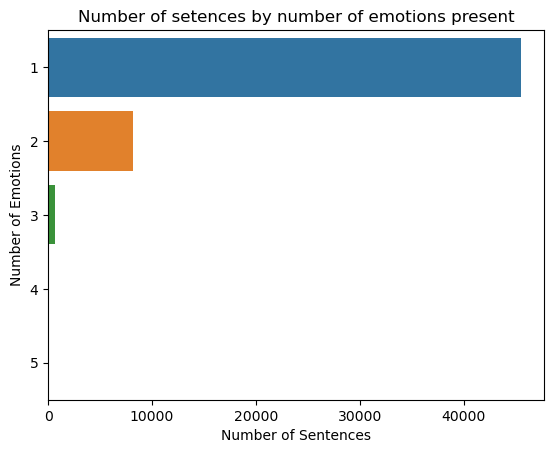

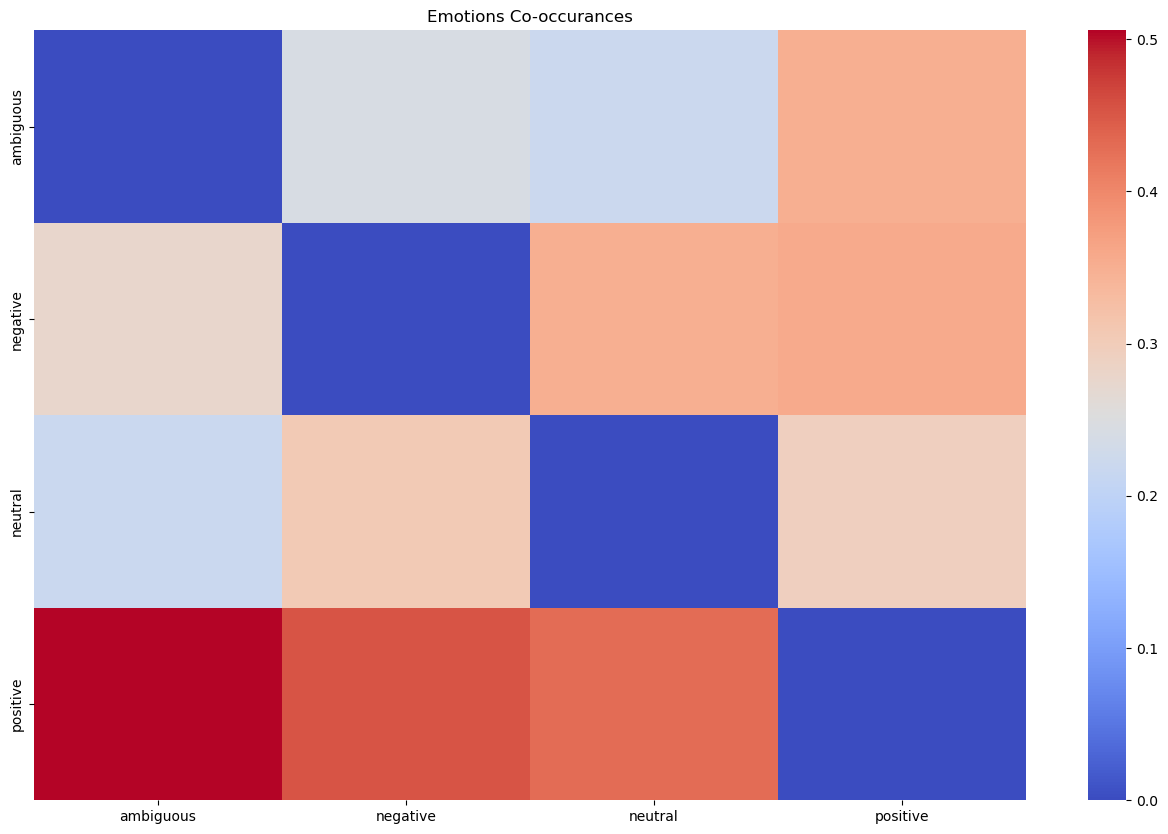

In [10]:
plot_emotions_cooccurences(classification="sentiment")

### Character and Token Length 

In [11]:
extended = (
    complete.assign(char_length=lambda f: f['text'].apply(lambda x : len(x)))
    .assign(token_length=lambda f: f['text'].apply(lambda x : len(x.split(" "))))
)

The vast majority of our sentences have less than 200 characters, and have a maximum of 33 tokens

C:\Users\pedro.forli\AppData\Local\Temp\ipykernel_14060\292427666.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(extended['char_length'])


Text(0, 0.5, 'Density')

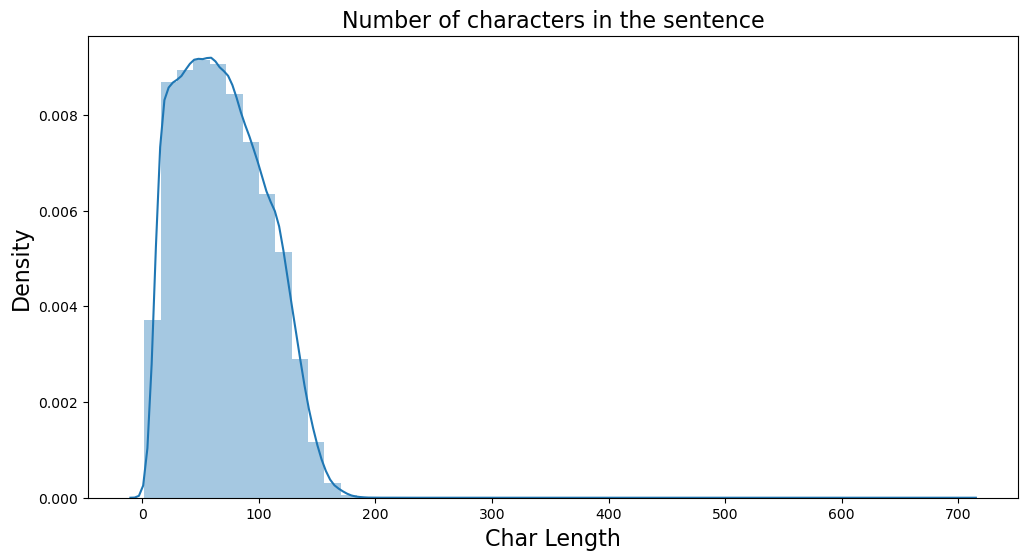

In [12]:
fig, ax  = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
ax = sns.distplot(extended['char_length'])
ax.set_title('Number of characters in the sentence', fontsize=16)
ax.set_xlabel('Char Length', fontsize=16)
ax.set_ylabel('Density', fontsize=16)

C:\Users\pedro.forli\AppData\Local\Temp\ipykernel_14060\1936597994.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(extended['char_length'], ax=ax1)
C:\Users\pedro.forli\AppData\Local\Temp\ipykernel_14060\1936597994.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(extended['token_length'],

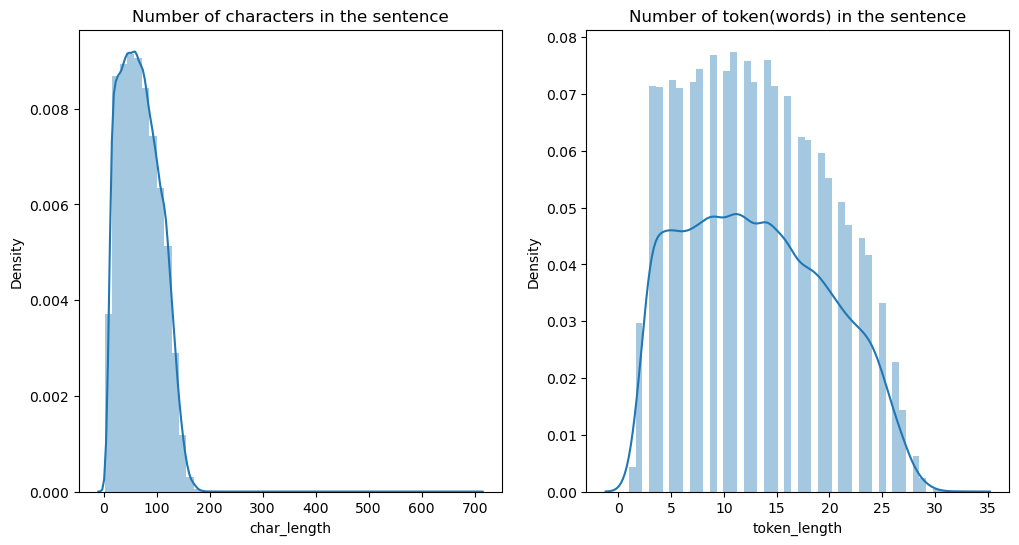

In [13]:
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
sns.distplot(extended['char_length'], ax=ax1)
sns.distplot(extended['token_length'], ax=ax2)
ax1.set_title('Number of characters in the sentence')
ax2.set_title('Number of token(words) in the sentence')
plt.show()

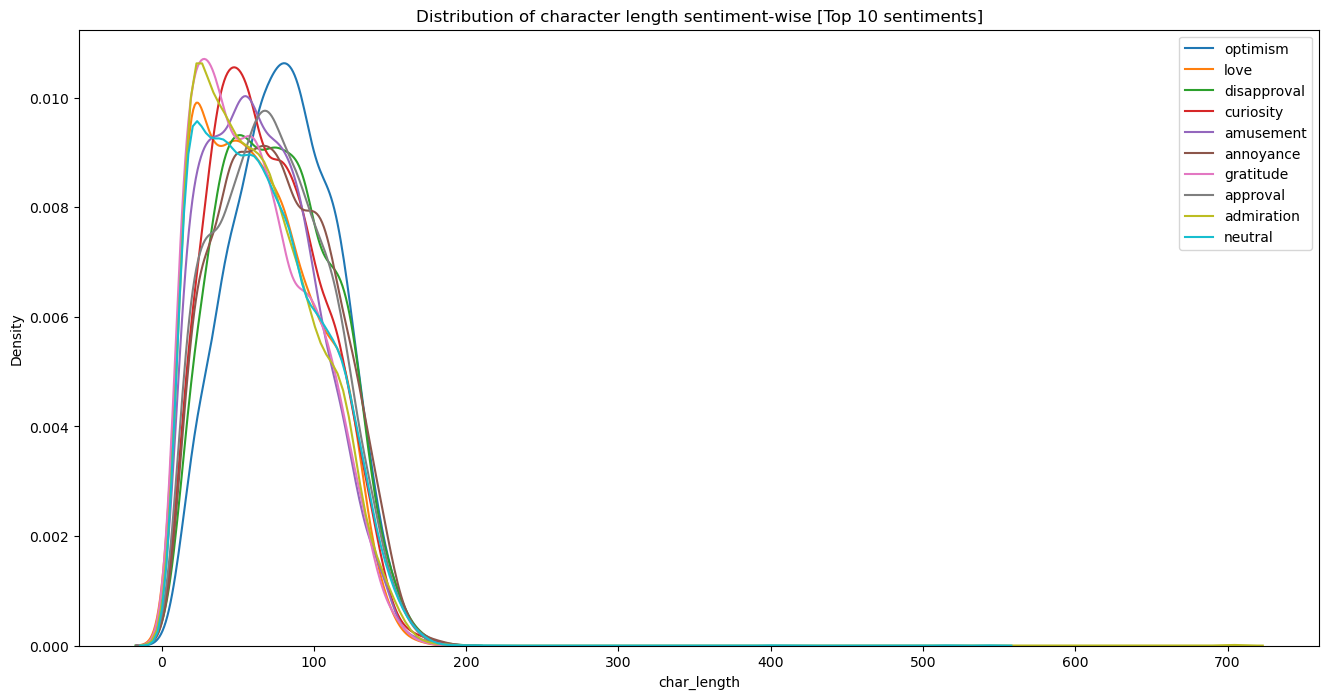

In [14]:
fig, ax = plt.subplots(figsize=(16 ,8))
for emotion in extended['goemotion'].value_counts().sort_values()[-10:].index.tolist():
    sns.kdeplot(extended[extended['goemotion']==emotion]['char_length'],ax=ax, label=emotion)
ax.legend()
ax.set_title("Distribution of character length sentiment-wise [Top 10 sentiments]")
plt.show()

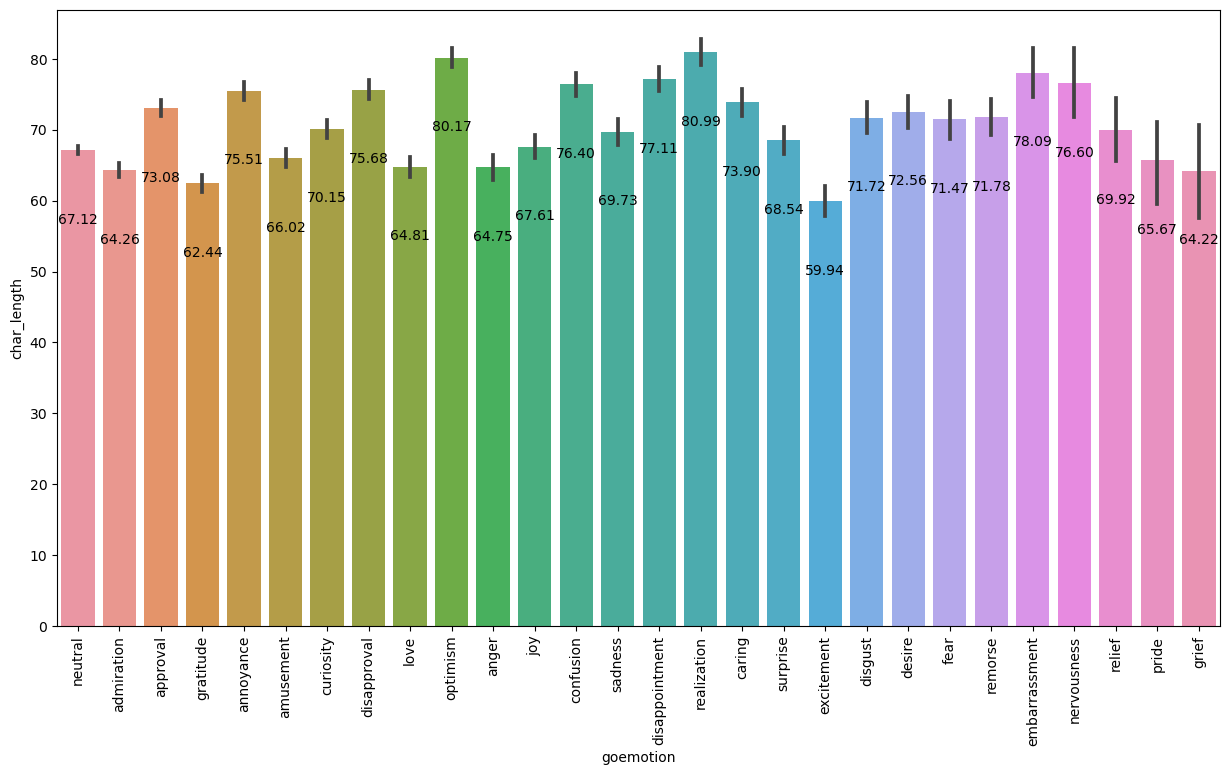

In [15]:
vc = extended['goemotion'].value_counts()
emotion_order = list(vc.index)

plt.figure(figsize=(15,8))

ax = sns.barplot(data=extended, x='goemotion', y='char_length', estimator=np.mean, order=emotion_order)
ax.set_xticklabels(emotion_order, rotation=90)

for p in ax.patches:
    ax.annotate(
        format(p.get_height(), '.2f'), 
        (p.get_x() + p.get_width() / 2., 
         p.get_height()), 
        ha = 'center', 
        va = 'center', 
        xytext = (0, -50), 
        textcoords = 'offset points'
    )

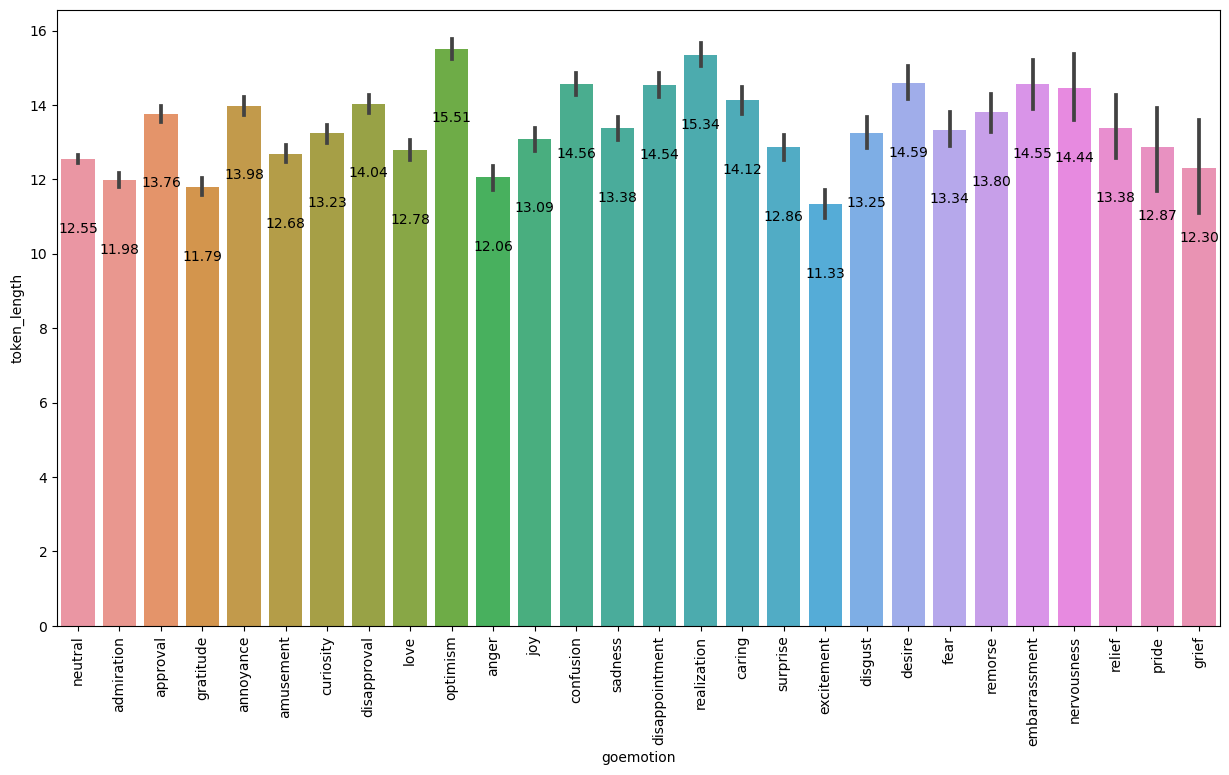

In [16]:
vc = extended['goemotion'].value_counts()
emotion_order = list(vc.index)

plt.figure(figsize=(15,8))

ax = sns.barplot(data=extended, x='goemotion', y='token_length', estimator=np.mean, order=emotion_order)
ax.set_xticklabels(emotion_order, rotation=90)

for p in ax.patches:
    ax.annotate(
        format(p.get_height(), '.2f'), 
        (p.get_x() + p.get_width() / 2., 
         p.get_height()), 
        ha = 'center', 
        va = 'center', 
        xytext = (0, -50), 
        textcoords = 'offset points'
    )

### Word Cloud 

In [17]:
complete.loc[lambda f: f["clean_text"].str.contains("\[EMOJI_")]

code   goemotion    ekman sentiment    set  \
32     ees2pfi  admiration      joy  positive  train   
33     ees2pfi   gratitude      joy  positive  train   
54     eejr2sg  admiration      joy  positive  train   
58     ee4w50c  admiration      joy  positive  train   
59     ee4w50c    approval      joy  positive  train   
...        ...         ...      ...       ...    ...   
63319  ef6ij1d     neutral  neutral   neutral   test   
63408  eeuhgqn     neutral  neutral   neutral   test   
63743  efgws64     neutral  neutral   neutral   test   
63772  eeemmzq     neutral  neutral   neutral   test   
63793  eexxip6     neutral  neutral   neutral   test   

                                                    text  \
32     I always just say “thank you” because it’s a n...   
33     I always just say “thank you” because it’s a n...   
54                                  That was brilliant 😂   
58     I appreciate this post, so it’s appropriate in...   
59     I appreciate this post, so it’s appropriate in...   
...                                                  ...   
63319  [NAME] doesn’t roll his ankle on a 🎾 in 2011 a...   
63408  Tell him his Gospels lack integrity due to the...   
63743                maybe now it'll go up to 3 an hour😎   
63772                              Apparently my state 😔   
63793  [NAME] might actually be able to pick her up a...   

                                              clean_text  
32     always say thank you nice thought [EMOJI_PERSO...  
33     always say thank you nice thought [EMOJI_PERSO...  
54              brilliant [EMOJI_FACE_WITH_TEARS_OF_JOY]  
58     appreciate post appropriate eye [EMOJI_GRINNIN...  
59     appreciate post appropriate eye [EMOJI_GRINNIN...  
...                                                  ...  
63319  [NAME] roll ankle [EMOJI_TENNIS] 2011 win prem...  
63408  tell gospel lack integrity due anonymity [EMOJ...  
63743  maybe go 3 hour [EMOJI_SMILING_FACE_WITH_SUNGL...  
63772              apparently state [EMOJI_PENSIVE_FACE]  
63793  [NAME] might actually able pick carry without ...  

[1463 rows x 7 columns]

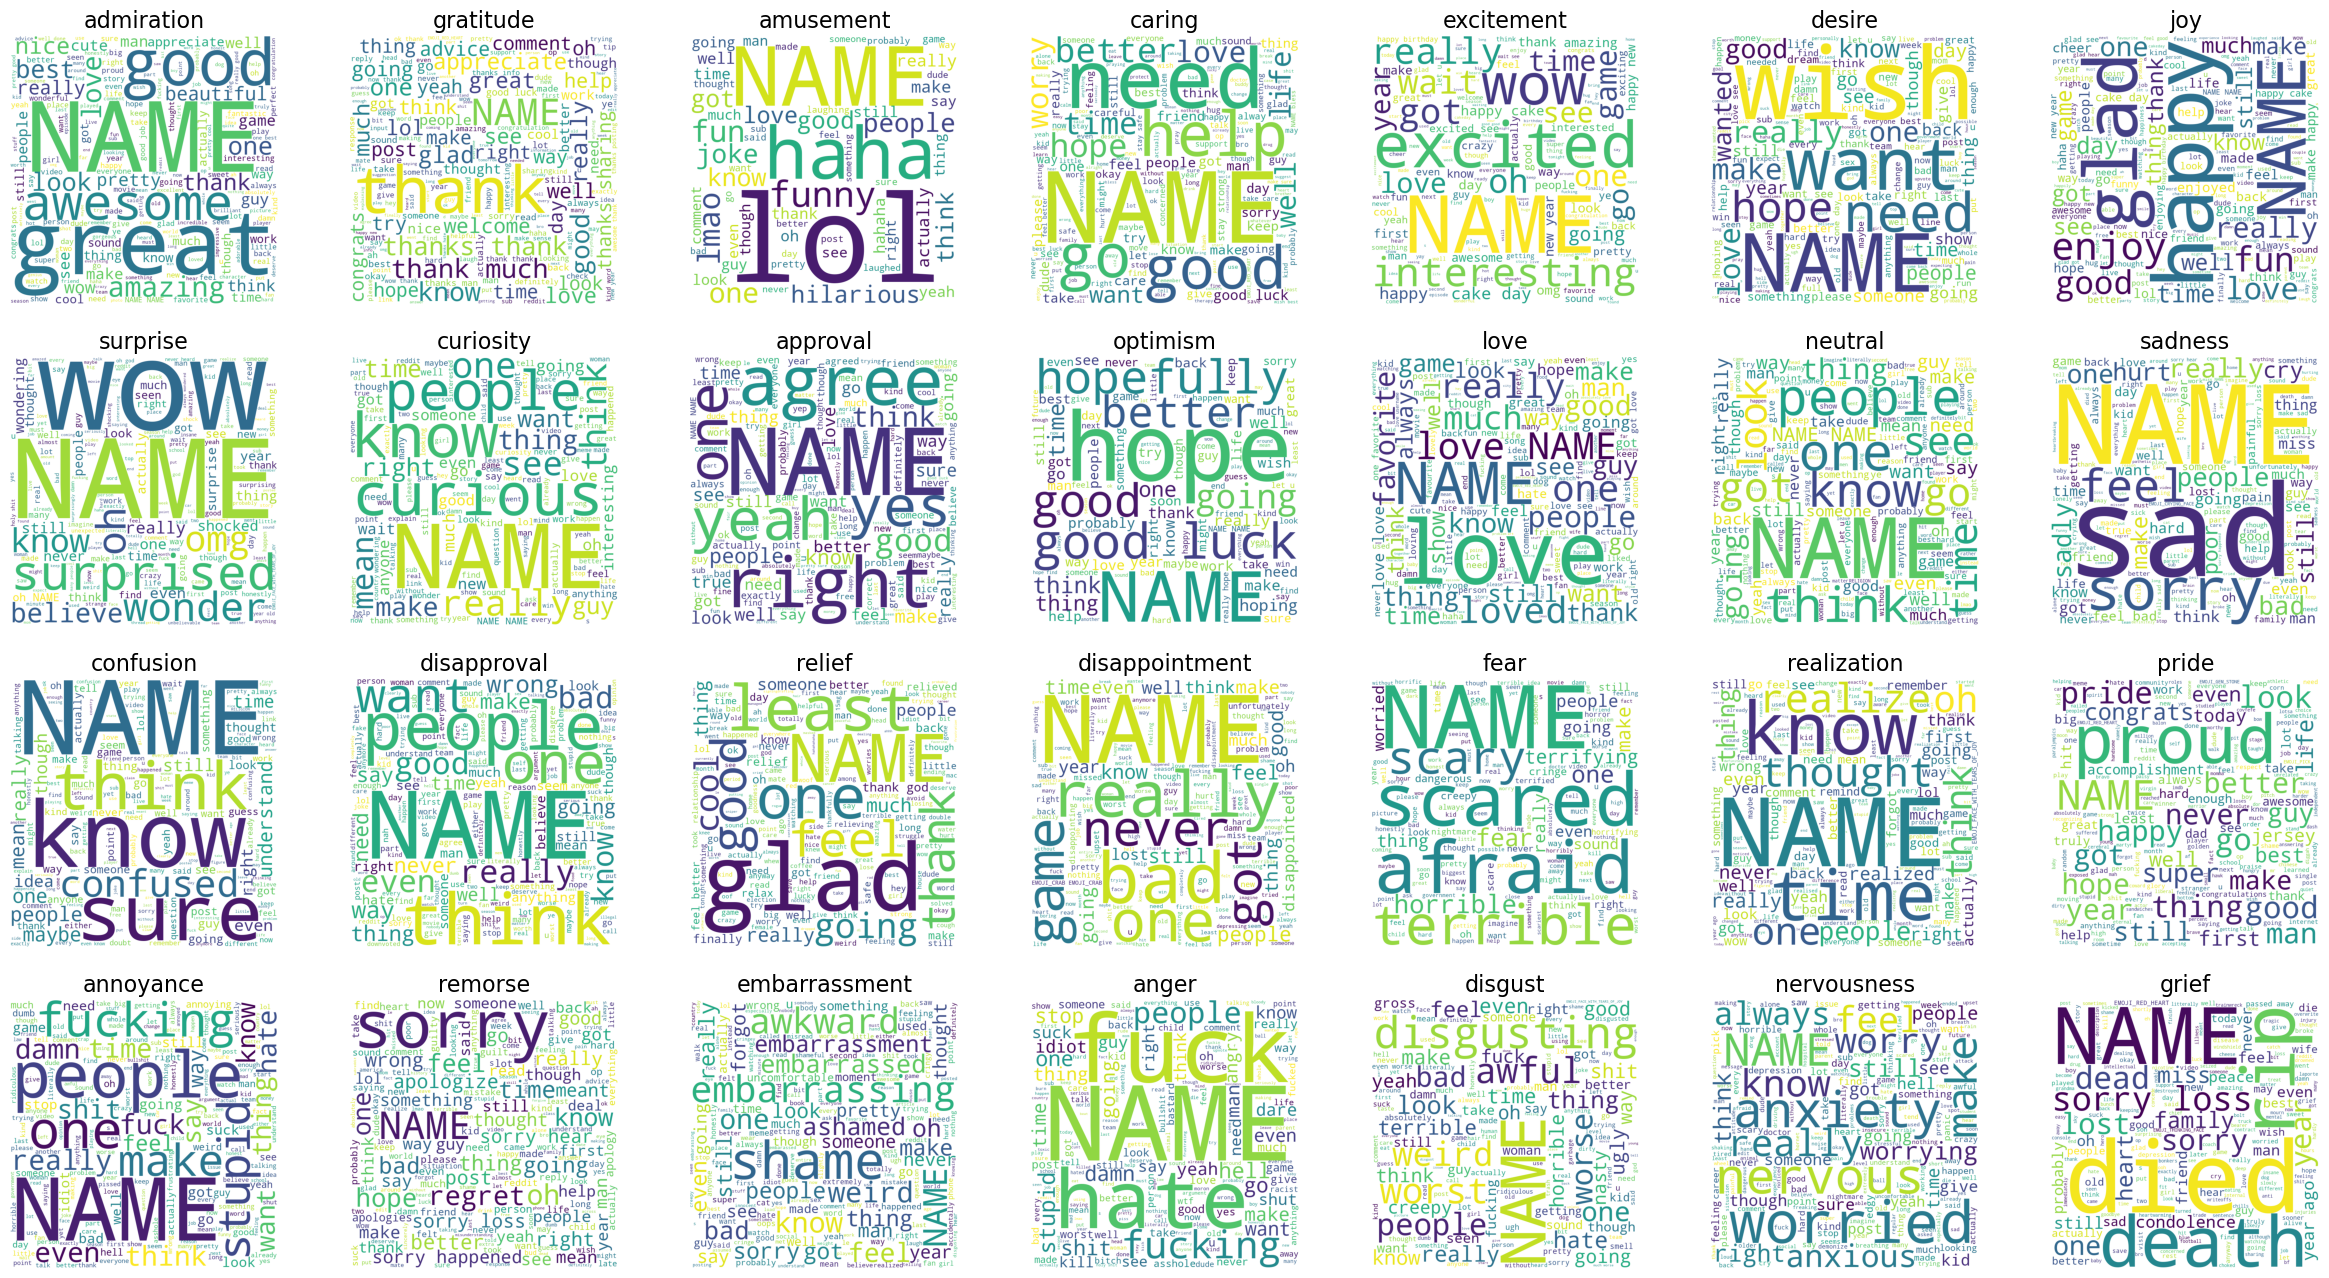

In [18]:
emotions = complete["goemotion"].unique()
emotions = list(emotions)

fig, axes = plt.subplots(nrows=4, ncols=7, figsize=(30, 16))

for ax, emotion in zip(axes.flatten(), emotions):
    text = " ".join(complete[complete["goemotion"] == emotion]["clean_text"])
    cloud = WordCloud(width=800, height=800, background_color="white", min_font_size=10).generate(text)
    ax.imshow(cloud)
    ax.set_title(emotion, fontsize=16)
    ax.axis("off")

plt.show()

---